# LIME Tabular API Notebook

This notebook is **tool-focused**: it demonstrates the **native programming interface of LIME (Local Interpretable Model-agnostic Explanations)** for **tabular classification**, plus a small helper wrapper to make common usage patterns less error-prone.

**Scope:**
- Uses a synthetic tabular dataset to keep the example self-contained.
- Shows how to initialize an explainer, explain an instance, visualize, and export explanations.

---

## What is LIME?

LIME explains an individual prediction by:
1. Creating **perturbed samples** around the instance to explain.
2. Querying your model’s **`predict_proba`** on those samples.
3. Fitting a **local, interpretable surrogate model** which is typically sparse linear regression model to approximate the behavior near that instance.
4. Returning **feature contributions** that describe why the model predicted the chosen class.

LIME is **model-agnostic**: it only requires a callable probability function and access to feature values.

## Native LIME objects

For tabular data, the key API objects and methods are:

- `lime.lime_tabular.LimeTabularExplainer(...)`
  - Construct an explainer with training data statistics and metadata.

- `explainer.explain_instance(x, predict_fn, num_features=..., top_labels=...)`
  - Explain a single instance `x` (1D array-like) using your model’s `predict_fn`.
  - `predict_fn` must return probabilities shaped `(n_samples, n_classes)`.

- `Explanation` object returned by `explain_instance`
  - `as_list(label=...)`: list of (feature, weight) pairs.
  - `as_map()`: raw feature-index map.
  - `as_pyplot_figure(label=...)`: matplotlib visualization.
  - `save_to_file("explanation.html")`: export an interactive HTML report.

In [1]:
# Imports
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

from lime_attrition_utils import (
    lime_build_tabular_explainer,
    lime_predict_proba_fn,
    lime_explain_instance,
    lime_explanation_to_df,
    LimeTabularWrapper,
)
np.random.seed(42)


## Step 1 — Create a small tabular classification dataset 

We use `make_classification` to generate a realistic-but-synthetic dataset with:
- numeric features
- correlated/ informative structure
- binary target

This keeps the notebook independent of any particular project dataset.

In [2]:
X, y = make_classification(
    n_samples=2500,
    n_features=12,
    n_informative=6,
    n_redundant=2,
    n_repeated=0,
    n_clusters_per_class=2,
    class_sep=1.0,
    flip_y=0.03,
    weights=[0.7, 0.3],  # class imbalance example
    random_state=42,
)

feature_names = [f"feature_{i}" for i in range(X.shape[1])]
class_names = ["Class 0", "Class 1"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Positive rate (train):", y_train.mean().round(3))

Train shape: (1875, 12) Test shape: (625, 12)
Positive rate (train): 0.309


## Step 2 — Train any probabilistic classifier

LIME requires a **probability** function. Many scikit-learn classifiers expose `predict_proba`.
We train a simple, standard baseline model:

- `StandardScaler` (preprocessing)
- `LogisticRegression` (probabilistic classifier)

This is purely for demonstrating the LIME API.

In [3]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)
acc = pipe.score(X_test, y_test)
print(f"Test accuracy: {acc:.3f}")

Test accuracy: 0.870


## Step 3 — Define the `predict_fn` for LIME

LIME calls your `predict_fn` on a 2D array of samples:
- Input shape: `(n_samples, n_features)`
- Output shape: `(n_samples, n_classes)` with probabilities

For scikit-learn pipelines, this is typically just `pipe.predict_proba`.

In [4]:
predict_fn = pipe.predict_proba

# Sanity check the interface expected by LIME:
proba = predict_fn(X_test[:5])
print("predict_fn output shape:", proba.shape)  # should be (5, 2)
print("Row sums (should be 1.0):", proba.sum(axis=1))

predict_fn output shape: (5, 2)
Row sums (should be 1.0): [1. 1. 1. 1. 1.]


## Step 4 — Initialize `LimeTabularExplainer`

Key arguments you commonly set:
- `training_data`: a representative sample from training features
- `feature_names`: list of human-readable names
- `class_names`: label names for display
- `mode`: `"classification"` for classifiers
- `discretize_continuous`: bins continuous features to improve interpretability

In [5]:
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,
    random_state=42,
)

### Using a helper wrapper to construct the explainer

The native API uses `LimeTabularExplainer(...)`. For convenience, I also provide a thin helper function that calls the same constructor with the same semantics.

In [6]:
explainer2 = lime_build_tabular_explainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,
    mode="classification",
    random_state=42,
)

# `explainer2` is functionally equivalent to `explainer` above
type(explainer2)

lime.lime_tabular.LimeTabularExplainer

## Step 5 — Explain a single prediction

We pick one test instance and:
1. compute the predicted probabilities
2. explain the prediction with LIME
3. display the top contributing features

Notes:
- `num_features` controls how many features appear in the explanation.
- `top_labels` controls how many class labels LIME explains. This is useful for multiclass.

In [7]:
i = 0
x = X_test[i]

pred = predict_fn(x.reshape(1, -1))[0]
pred_label = int(np.argmax(pred))
print("Predicted probabilities:", dict(zip(class_names, pred.round(3))))
print("Predicted class:", class_names[pred_label])

exp = explainer.explain_instance(
    data_row=x,
    predict_fn=predict_fn,
    num_features=10,
    top_labels=1,  # explain the top predicted label
)

# Human-readable list of (feature, weight)
exp_list = exp.as_list(label=pred_label)
pd.DataFrame(exp_list, columns=["feature_condition", "weight"])

Predicted probabilities: {'Class 0': np.float64(0.976), 'Class 1': np.float64(0.024)}
Predicted class: Class 0


,feature_condition,weight
0,feature_7 <= -1.62,0.309738
1,feature_4 <= -1.31,-0.257312
2,feature_5 <= -1.99,0.127358
3,feature_0 <= -2.27,0.111311
4,feature_10 <= -1.78,0.107823
5,0.41 < feature_2 <= 1.50,-0.060268
6,-1.04 < feature_11 <= -0.07,-0.016464
7,feature_1 <= -1.15,-0.013349
8,-0.05 < feature_6 <= 0.73,0.011934
9,feature_8 <= -0.66,-0.008783


### Using a thin helper function to call `explain_instance` and turn it into a table

This does exactly the same thing as calling `explainer.explain_instance(...)` directly. it just standardizes the call signature and returns a compact DataFrame.

In [8]:
exp2 = lime_explain_instance(
    explainer=explainer,
    data_row=x,
    predict_fn=predict_fn,
    num_features=10,
    num_samples=5000,
)

lime_explanation_to_df(exp2, top_k=10)

,feature,weight,abs_weight
0,feature_7 <= -1.62,-0.318482,0.318482
1,feature_4 <= -1.31,0.255056,0.255056
2,feature_5 <= -1.99,-0.134511,0.134511
3,feature_0 <= -2.27,-0.112564,0.112564
4,feature_10 <= -1.78,-0.095234,0.095234
5,0.41 < feature_2 <= 1.50,0.040287,0.040287
6,-1.04 < feature_11 <= -0.07,0.013343,0.013343
7,0.03 < feature_3 <= 0.71,0.004106,0.004106
8,feature_1 <= -1.15,0.001833,0.001833
9,-0.05 < feature_6 <= 0.73,0.001366,0.001366


## Step 6 — Visualize and export the explanation

Common outputs:
- Matplotlib figure (`as_pyplot_figure`)
- Interactive HTML report (`save_to_file`)



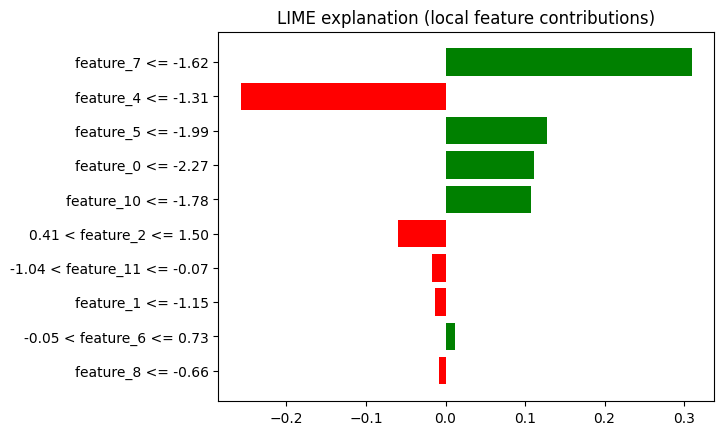

Saved: outputs/lime_tabular_explanation.html


In [9]:
fig = exp.as_pyplot_figure(label=pred_label)
plt.title("LIME explanation (local feature contributions)")
plt.show()

# Export to HTML
import os
os.makedirs("outputs", exist_ok=True)
html_path = os.path.join("outputs", "lime_tabular_explanation.html")
exp.save_to_file(html_path)
print("Saved:", html_path)

## Step 7 — A lightweight wrapper

Below is a small helper wrapper that:
- validates shapes
- standardizes outputs into a dictionary
- returns the predicted probabilities and the top-k LIME features

This wrapper is tool-centric and can be reused in other projects without modification.

The wrapper implementation is placed in a small helper module (`utils.py`) so the notebook stays minimal and the logic is reusable.


In [10]:
# lightweight helper wrapper to standardize common usage
wrapper = LimeTabularWrapper(explainer=explainer, predict_fn=predict_fn, class_names=class_names)

demo_df = wrapper.explain(X_test[1], top_k=8, num_samples=5000)
demo_df


,feature,weight,abs_weight
0,feature_4 > 1.23,-0.235435,0.235435
1,-1.62 < feature_7 <= -0.59,-0.146505,0.146505
2,feature_0 > 1.52,0.121357,0.121357
3,feature_5 > 1.87,0.115510,0.115510
4,0.41 < feature_2 <= 1.50,0.036330,0.036330
5,-1.78 < feature_10 <= -0.76,-0.035699,0.035699
6,-0.67 < feature_3 <= 0.03,-0.009728,0.009728
7,feature_11 <= -1.88,-0.008684,0.008684


## Notes on limitations and good practice

- **Stability:** LIME uses random perturbations; set `random_state` and consider repeating explanations to assess variance.
- **Preprocessing:** Ensure `predict_fn` applies the *same preprocessing* as the model expects.
- **Feature semantics:** Discretization can improve readability, but can also change how conditions are shown.
- **Local vs global:** LIME explains *one prediction*, not global feature importance.